# Code for figure

In [55]:
from graph_tool.all import *
import pickle
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys

import collections
from collections import Counter
from matplotlib.lines import Line2D
import csv

from scipy import stats
import json


import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm 
from sklearn.neighbors import KernelDensity 
from sklearn.utils.fixes import parse_version

#%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})
    #matplotlib.rcParams.update({'font.size': 18})

In [56]:
# importing all our functions 
from functions_reci_bursty import *

In [57]:
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch


# This is a function to adjust the space bw boxplots
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [58]:
# a more general path that works for all -sam
x=os.getcwd().split('/');
x=os.getcwd().replace(x[len(x)-1],'')
os.chdir(x+'data')

# Adri's path
# os.chdir('/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data')

# Elsa's path
#os.chdir('/home/utilisateur/Desktop/Dynamical_project/data')

In [59]:
#Path to save the figures
fig_path = x+'fig' # adri

# fig_path = '/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/fig' # adri
#fig_path= '/home/utilisateur/Desktop/Dynamical_project/fig/' #elsa

In [60]:
fig_path

'/mnt/sdb1/sandeep/1.Reciprocity/fig'

# TABLE
____

In [61]:
def table(g_filt):
    
    # TABLE
    #-------------------------------------
    DATA = {}
    DATA['Nber_events'] = sum([g_filt.ep.n_events[v] for v in g_filt.edges()])
    DATA['Nber_links'] = g_filt.num_edges()
    DATA['Nber_nodes'] = g_filt.num_vertices() 
    
    DATA['Proba_rec_event'] = np.mean([g_filt.ep.p_Erec[v] for v in g_filt.edges()])
    DATA['Proba_rec_edge'] = sum([1 for v in g_filt.edges() if g_filt.ep.p_Erec[v]!= 0]) / g_filt.num_edges()
    
    DATA['Burst_nodes'] = np.nanmean([g_filt.vp.burst[v] for v in g_filt.vertices()])
    
    DATA['Burst_edges'] = np.nanmean([g_filt.ep.burts[e] for e in g_filt.edges()])

    return(DATA)

In [62]:
TAB = pd.DataFrame(columns = ['Nber_events', 'Nber_links', 'Nber_nodes', 'Proba_rec_event', 'Proba_rec_edge', 'Burst_nodes', 'Burst_edges', 'data'])

names = ['calls','sms','msg','email', 'retweets', 'reply', 'mentions']
for name in names: 
    print('\t working on: ', name)
    
    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()
    
    
    dict_tab = table(g_filt)
    dict_tab['data'] = name
    
    TAB = TAB.append(dict_tab, ignore_index=True)

	 working on:  calls
	 working on:  sms
	 working on:  msg
	 working on:  email
	 working on:  retweets
	 working on:  reply
	 working on:  mentions


In [63]:
TAB 

,Nber_events,Nber_links,Nber_nodes,Proba_rec_event,Proba_rec_edge,Burst_nodes,Burst_edges,data
0,2870.0,339,376,0.466797,0.814159,0.071288,-0.145102,calls
1,24255.0,627,542,0.746506,0.966507,0.381904,0.184502,sms
2,54185.0,8442,1313,0.653650,0.764985,0.246534,-0.306238,msg
3,323707.0,11429,803,0.463504,0.775658,0.422887,-0.057135,email
4,74360.0,10222,6349,0.113054,0.201722,-0.251394,-0.479282,retweets
5,612.0,105,487,0.304271,0.438095,-0.240752,-0.372823,reply
6,263443.0,23698,7379,0.143857,0.269474,-0.169805,-0.374098,mentions


# FIGURES
---

## FUNCTIONS
___

In [64]:
# Function to convert network properties into a dataFrame. 

def data_prep(g_filt):

    # CREATING DFs
    #-------------------------------------
    #  a. Build a df for nodes 
    df_nodes = pd.DataFrame([g_filt.vp[p] for p in dict(g_filt.vertex_properties).keys()]).T
    df_nodes.columns = dict(g_filt.vertex_properties).keys()

    for col in ['burst_no_rec', 'burst_rec', 'n_rec_event','n_rec_link', 'proba_rec_event','proba_rec_link', 'burst']:
        df_nodes[col] = df_nodes[col].apply(float)

    for col in ['intertime_no_rec', 'intertime_rec', 'intertime']:
        df_nodes[col] = df_nodes[col].apply(lambda x: np.asarray(x))
        
        
    # b. Build a df for edges
    df_edges = pd.DataFrame([g_filt.ep[p] for p in dict(g_filt.edge_properties).keys()]).T
    df_edges.columns = dict(g_filt.edge_properties).keys()
    
    return df_nodes, df_edges

# NODES
____

## PLOTS FIGURE 1

In [65]:
def cum_F_x(dd):
    dist = Counter(dd)
    sorted_tuples = sorted(dist.items(), key=lambda item: item[0])
    sorted_dict = {k: v for k, v in sorted_tuples}
    
    x = np.array(list(sorted_dict.keys()))
    y = np.array(list(sorted_dict.values()))

    y_cum = np.cumsum(y)
    y_cum = y_cum/sum(y)
    return x, 1-y_cum

In [66]:
def F_x_bins(dd):
    dist = np.histogram(dd, bins = 100)
    y = dist[0]
    x =  [(dist[1][c]+dist[1][c+1])/2 for c in range(len(dist[1])-1)]
    #y = y/max(y)
    return x, y

In [67]:
names = ['calls','sms','msg','email', 'retweets', 'reply', 'mentions']# 'msg','email'] 

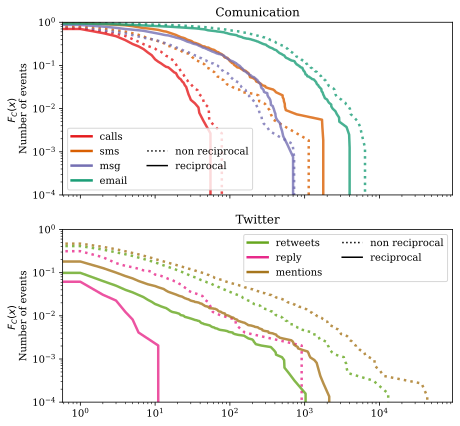

In [69]:
#-- New figure for you elsa with love adriana 

fig, axs = plt.subplots(2, 1, figsize =(3.5*2, 3.5*2), sharey='col', sharex='col')

c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']

titles  = ['Comunication', 'Twitter']
lines   = [':', '-']

type_1 = ['n_non_rec_event', 'n_rec_event']

for i in range(2):
    for j,name in enumerate(names):  
        if j>3:
            col = 1
        else:
            col = 0
            

        # - Uploading graphs: g_filt !
        #------------------------------------------    
        name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
        g_filt = pickle.load(name_store)
        name_store.close()

        # - Preparing data 
        df_nodes = data_prep(g_filt)[0]
        df_nodes['n_non_rec_event'] = df_nodes['intertime_no_rec'].apply(len)
        
        #df_nodes['p_non_rec_event'] = df_nodes['n_non_rec_event']/max(df_nodes['n_non_rec_event'])
        #df_nodes['p_rec_event'] = df_nodes['n_rec_event']/max(df_nodes['n_rec_event'])

        # --- Number of Events  
        type_ = type_1[i]
        
        dd = np.array(df_nodes[type_])
        x,y = cum_F_x(dd)
        
        # Titles
        axs[col].set_title(titles[col])
        
        # Lines
        axs[col].plot(x, y, alpha = 0.8, ls = lines[i], label = name, c = c[j], lw=2.5 )
        axs[col].set_yscale('log')
        axs[col].set_xscale('log')
        axs[col].set_ylim(10**-4,10**0)
        
        # y axis Labels
        axs[col].set_ylabel('$F_{C}(x)$ \nNumber of events')

# Legend
custom_lines1 = [Line2D([0], [0], color=col, lw=2.5) for col in c[:4]]
custom_lines2  = [Line2D([0], [0], color='k', lw=1.5, ls=l) for l in [':', '-']]

custom_lines = [*custom_lines1, *[Line2D([0], [0], color='white', lw=3)], *custom_lines2]

axs[0].legend(custom_lines, ['calls','sms', 'msg','email',' ',
                               'non reciprocal', 'reciprocal'], ncol = 2)

custom_lines1 = [Line2D([0], [0], color=col, lw=2.5) for col in c[4:]]
custom_lines2  = [Line2D([0], [0], color='k', lw=1.5, ls=l) for l in [':', '-']]

custom_lines = [*custom_lines1, *custom_lines2]
axs[1].legend(custom_lines, ['retweets', 'reply', 'mentions', 'non reciprocal', 'reciprocal'], ncol = 2)
    
plt.show()
fig.savefig(fig_path+'/fig1.pdf')

In [ ]:
# try: burstiness vs p rec

In [73]:
df_comm_nodes = pd.DataFrame()
df_tw_nodes = pd.DataFrame()


for j,name in enumerate(names):  
    print(name)
    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()
    
    
    # - Preparing data 
    df_nodes = data_prep(g_filt)[0]
        
    df_nodes['proba_rec_event_bin'] = pd.cut(df_nodes['proba_rec_event'], bins=[0.2, 0.4, .6, .8, 1])#q=[0.1, 0.6, .7, .8, .9, 1])#labels=False,precision=0)
        
    df_nodes['dataset'] = name
    if j <4:
        df_comm_nodes = pd.concat([df_comm_nodes,df_nodes])
    else:
        df_tw_nodes = pd.concat([df_tw_nodes,df_nodes])

calls
sms
msg
email
retweets
reply
mentions


<ipython-input-57-bfdbdd1df548>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


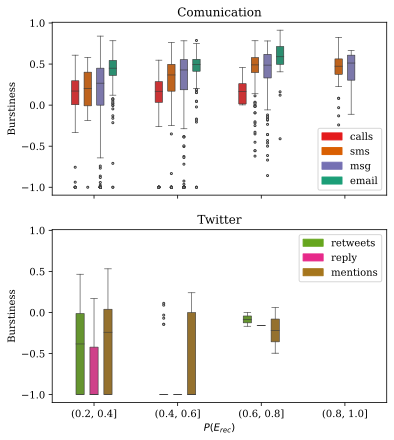

In [74]:
c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']
titles  = ['Comunication', 'Twitter']


fig, axs = plt.subplots(2, 1, figsize =(3*2, 3.5*2), sharey='col', sharex='col')


sns.boxplot(x="proba_rec_event_bin", y="burst",hue="dataset", palette=c[:4],data=df_comm_nodes, ax = axs[0], width = 0.6,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

sns.boxplot(x="proba_rec_event_bin", y="burst",hue="dataset", palette=c[4:],data=df_tw_nodes, ax = axs[1], width = 0.5,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

adjust_box_widths(fig, 0.6)

for col in range(2):
    #Label
    axs[col].set_ylabel('Burstiness')
    
    # Titles
    axs[col].set_title(titles[col])
axs[0].set_xlabel('')
axs[1].set_xlabel('$P(E_{rec})$')
    
# Legend
custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[:4]]
axs[0].legend(custom_lines1, ['calls','sms', 'msg','email'], ncol = 1)

custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[4:]]
axs[1].legend(custom_lines1, ['retweets', 'reply', 'mentions',], ncol = 1)
    
plt.show()
fig.savefig(fig_path+'/figSI1.pdf')

## PLOTS FIGURE 2

## Doing bootstrap
----

In [75]:
# BOOTSTRAP 
def boot(df_nodes):
    N_ex = 2000
    sample_size = 1000

    B_mean = []
    B_std = []

    Inter_mean = []
    Inter_std =[]

    for ex in range(N_ex):
        df_sample = df_nodes.sample(n=sample_size, replace=True, axis=0) 

        # Burstiness
        B_mean.append(df_sample.describe().loc['mean',:][['burst_no_rec', 'burst_rec', 'burst']])
        B_std.append(df_sample.describe().loc['std',:][['burst_no_rec', 'burst_rec', 'burst']])

        # Intertime
        I_no_rec = np.concatenate(list(df_sample['intertime_no_rec']))
        I_rec = np.concatenate(list(df_sample['intertime_rec']))
        I_all = np.concatenate(list(df_sample['intertime']))

        Inter_mean.append([np.mean(I_no_rec), np.mean(I_rec), np.mean(I_all)])
        Inter_std.append([np.std(I_no_rec), np.std(I_rec), np.std(I_all)])

    B_mean = np.array(B_mean).T
    B_std = np.array(B_std).T

    Inter_mean = np.array(Inter_mean).T
    Inter_std = np.array(Inter_std).T
    
    return B_mean, B_std, Inter_mean, Inter_std

names = ['calls','sms', 'msg','email', 'retweets', 'reply', 'mentions', ]#'test']# 'msg','email'] 
##['calls', 'sms', 'mentions','retweets', 'reply','msg','email'

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [76]:
names = ['calls','sms', 'msg','email', 'retweets', 'reply', 'mentions', ]#'test']# 'msg','email'] 


In [77]:
# DOING BOOTSTRAP

DATA = {}

for col,name in enumerate(names): 
    print(name)
        
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()
      
    
    # Preparing data
    df_nodes = data_prep(g_filt)[0]
    
    # Running the bootstrap
    B_mean, B_std, Inter_mean, Inter_std = boot(df_nodes)
    
    # - Computing t test
    pvalue_B_tt = np.round(stats.ttest_ind(B_mean[0],B_mean[1])[0], 3)
    pvalue_InterM_tt = np.round(stats.ttest_ind(Inter_mean[0],Inter_mean[1])[0],3)
    pvalue_InterStd_tt = np.round(stats.ttest_ind(Inter_std[0],Inter_std[1])[0],3)
    
    # - Computing ks
    pvalue_B_ks = np.round(stats.ks_2samp(B_mean[0],B_mean[1], alternative='two-sided', mode='asymp')[0],3)
    pvalue_InterM_ks = np.round(stats.ks_2samp(Inter_mean[0],Inter_mean[1], alternative='two-sided', mode='asymp')[0],3)
    pvalue_InterStd_ks = np.round(stats.ks_2samp(Inter_std[0],Inter_std[1], alternative='two-sided', mode='asymp')[0],3)
    
    # - Storing 
    DATA[name] = {'B_mean': B_mean, 
                  'B_std': B_std,
                  
                  'pvalue_B_tt' : pvalue_B_tt,
                  'pvalue_InterM_tt' : pvalue_InterM_tt,
                  'pvalue_InterStd_tt' : pvalue_InterStd_tt,
                  
                  'pvalue_B_ks' : pvalue_B_ks,
                  'pvalue_InterM_ks' : pvalue_InterM_ks,
                  'pvalue_InterStd_ks' : pvalue_InterStd_ks,
                  
                  'Inter_mean': Inter_mean, 
                  'Inter_std': Inter_std }
    
    #‘exact’, ‘asymp’
    #pvalue_B = stats.ks_2samp(B_mean[0],B_mean[1], alternative='two-sided', mode='asymp')[1]
    #pvalue_InterM= stats.ks_2samp(Inter_mean[0],Inter_mean[1], alternative='two-sided', mode='asymp')[1]
    #pvalue_InterStd= stats.ks_2samp(Inter_std[0],Inter_std[1], alternative='two-sided', mode='asymp')[1]
    
# Save DATA
a_file = open("/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data/DATA.pkl", "wb")
pickle.dump(DATA, a_file)
a_file.close()

calls
sms
msg
email
retweets
reply
mentions


FileNotFoundError: [Errno 2] No such file or directory: '/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data/DATA.pkl'

In [ ]:
# LOAD DATA
a_file = open("./DATA.pkl", "rb")
DATA = pickle.load(a_file)
#print(DATA)

---

In [ ]:
fig, axs = plt.subplots(3, len(DATA.keys()), figsize =(3*len(DATA.keys()), 7))#, sharex='row') #sharey='row'
c = ['blue', 'orange', 'grey']

param_fit = [0.01,0.01,0.05,0.05,0.4,0.2,0.4]
param_fit_burst = [0.05,0.05,0.05,0.05,0.05,0.05,0.05]

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

for col, name in enumerate(DATA.keys()):
    
    fit = param_fit[col]    
    fit_burst = param_fit_burst[col]
    
    # - Setting the name of the column (dataset)
    axs[0,col].set_title(name)   

    # Preparing data
    data = DATA[name]
      
    # AM: This is actually unuseful we could already imput the values from the dict...
    B_mean= data['B_mean']
    B_std= data['B_std']
    Inter_mean= data['Inter_mean']
    Inter_std= data['Inter_std']
    
    pvalue_B_tt = data['pvalue_B_tt']
    pvalue_InterM_tt = data['pvalue_InterM_tt']
    pvalue_InterStd_tt = data['pvalue_InterStd_tt']
    
    pvalue_B_ks = data['pvalue_B_ks']
    pvalue_InterM_ks = data['pvalue_InterM_ks']
    pvalue_InterStd_ks = data['pvalue_InterStd_ks']
    
    
    scale = 60*60*24
    x_scale = 'Days'

    for i,label in enumerate(['Non-Reciprocal','Reciprocal', 'Overall']): 
        
        if label == 'Overall':
            alpha = 0.7
        else:
            alpha = 1
            
        # -- Intertime Mean
        
        Inter_mean_plot = Inter_mean[i]/scale
        
        # Adriana and Elsa code
        #sns.kdeplot(Inter_mean_plot, color=c[i], ax=axs[0,col],common_norm = True,label=label)
        
        # Sandeep code
        kde = KernelDensity(kernel='gaussian', bandwidth=fit).fit(Inter_mean_plot.reshape(-1, 1)) 
        s = np.linspace(0,round(max(Inter_mean_plot)+1),num = 100) 
        log_dens = kde.score_samples(s.reshape(-1,1)) 
        
        axs[0,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
        axs[0,col].hist(Inter_mean_plot,alpha = 0.25,density=True, edgecolor = c[i])
        axs[0,col].axvline(np.mean(Inter_mean_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
        axs[0,col].set_xlabel(x_scale)
        
        
        # -- Intertime Std
        
        #Inter_std[i] = Inter_std[i]/scale
        
        Inter_std_plot = Inter_std[i]/scale
        #sns.kdeplot(Inter_std_plot, color=c[i], ax=axs[1,col], common_norm = True,label=label)
        
        # Sandeep code
        kde = KernelDensity(kernel='gaussian', bandwidth=fit).fit(Inter_std_plot.reshape(-1, 1)) 
        s = np.linspace(0,round(max(Inter_std_plot)+1),num = 100) 
        log_dens = kde.score_samples(s.reshape(-1,1)) 
        
        axs[1,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
        axs[1,col].hist(Inter_std_plot,alpha = 0.25, density=True, edgecolor = c[i])
        axs[1,col].axvline(np.mean(Inter_std_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
        axs[1,col].set_xlabel(x_scale)
    
            
        # -- Burstiness
        
        B_mean_plot = B_mean[i]
                
        # Sandeep code
        kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(B_mean_plot.reshape(-1, 1)) 
        s = np.linspace(-1,1,num = 100) 
        log_dens = kde.score_samples(s.reshape(-1,1)) 
        
        
        axs[2,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
        axs[2,col].hist(B_mean_plot,alpha = 0.25,density=True, edgecolor = c[i])
        axs[2,col].axvline(np.mean(B_mean_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
        axs[2,col].set_xlim(-0.6, 0.6) #<--- AM: I changed the range make the x axis larger
        axs[2,col].set_xlabel('Burtiness')
        
        #axs[2,col].set_ylim(0, 9)
        
    for j in range(3):
        axs[j,col].set_ylabel('')

f = 10
axs[0,0].set_ylabel('$P_{x}(Intertime \; Mean)$',fontsize=f)
axs[1,0].set_ylabel('$P_{x}(Intertime \; Std)$',fontsize=f)
axs[2,0].set_ylabel('$P_{x}(Burstiness \; Mean)$\n',fontsize=f)

fig.align_ylabels(axs[:, 0])
axs[2,3].legend(loc='lower center', ncol = 3, bbox_to_anchor=(0.5, -0.6))
       
fig.tight_layout(pad=2.0)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.35)
fig.savefig(fig_path+'/fig2.pdf')

# EDGES 
____

In [77]:
names = ['calls', 'sms', 'msg', 'email', 'retweets', 'reply','mentions']

In [78]:
df_comm = pd.DataFrame()
df_tw = pd.DataFrame()


for j,name in enumerate(names):  
    print(name)

    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()

    # - Preparing data 
    df_nodes = data_prep(g_filt)[1]
    df_nodes['dataset'] = 'name'
    #df_nodes = df_nodes[df_nodes['balance']!= 1]
        
    df_nodes['balance_bin'] = pd.cut(df_nodes['balance'], bins=5)#q=[0.1, 0.6, .7, .8, .9, 1])#labels=False,precision=0)
        
    df_nodes['dataset'] = name
    if j <4:
        df_comm = pd.concat([df_comm,df_nodes])
    else:
        df_tw = pd.concat([df_tw,df_nodes])
            

calls
sms
msg
email
retweets
reply
mentions


<ipython-input-51-bfdbdd1df548>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


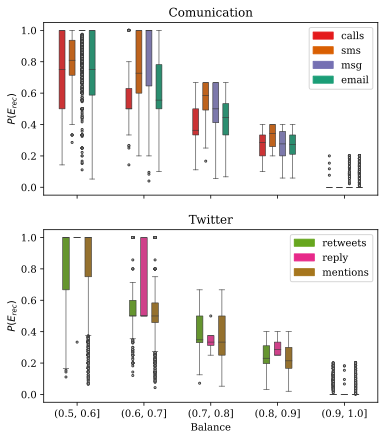

In [79]:
c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']
titles  = ['Comunication', 'Twitter']


fig, axs = plt.subplots(2, 1, figsize =(3*2, 3.5*2), sharey='col', sharex='col')


sns.boxplot(x="balance_bin", y="p_Erec",hue="dataset", palette=c[:4],data=df_comm, ax = axs[0], width = 0.6,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

sns.boxplot(x="balance_bin", y="p_Erec",hue="dataset", palette=c[4:],data=df_tw, ax = axs[1], width = 0.5,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

adjust_box_widths(fig, 0.6)

for col in range(2):
    #Label
    axs[col].set_ylabel('$P(E_{rec})$')
    
    # Titles
    axs[col].set_title(titles[col])
axs[0].set_xlabel('')
axs[1].set_xlabel('Balance')
    
# Legend
custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[:4]]
axs[0].legend(custom_lines1, ['calls','sms', 'msg','email'], ncol = 1)

custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[4:]]
axs[1].legend(custom_lines1, ['retweets', 'reply', 'mentions',], ncol = 1)
    
plt.show()
fig.savefig(fig_path+'/fig3.pdf')

In [80]:
#---- end 

## Testing isomorphism of graphs saved vs graphs created

In [30]:
from graph_tool.all import *
import pickle
import matplotlib
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import random
import math
import collections
import csv
import timeit

def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
start_time = timeit.default_timer()

#%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
#matplotlib.rcParams.update({'font.size': 18})

from functions_reci_bursty import *
from statistics import *

from AD_model_power_law import *

from multiprocessing import Process
from joblib import Parallel, delayed


path_code='/mnt/sdb1/sandeep/1.Reciprocity/code/'
path_data='/mnt/sdb1/sandeep/1.Reciprocity/data/data_raw/'
path_results='/mnt/sdb1/sandeep/1.Reciprocity/res/'

In [48]:
with open(path_data+'sms_ijt.pickle', 'rb') as handle:
    sms_data = pickle.load(handle)

df_edges = pd.DataFrame(sms_data, columns = ['from', 'to', 't_second'])


# df_edges_college = pd.read_table(
#     path_data+'CollegeMsg.txt',header=None,sep=" ")
# df_edges_college.columns = ['from', 'to', 't_second']
# # print(df_edges_email)




df_edges.drop_duplicates(inplace=True)
g,g_D = to_graph(df_edges,'from','to','t_second','t_minutes','t_hours','t_days')



### LOADING FROM ADRI
name = 'sms'
    
g_D_ = load_graph('./graphs_raw/'+name+"_g_d.xml.gz")
g_ = load_graph('./graphs_raw/'+name+"_g.xml.gz")






# # Do stuff on nodes
# g = rec_nodes(g_D,g)
# g = burst_rec_nodes(g_D,g)
# g = burst_no_rec_nodes(g_D,g)
# g = burst_nodes(g_D,g)

# # Do stuff on edges
# g= compute_link_prop(g,g_D)

# g_filt=graph_filter_func(g,g_D)



# Y=measures(df_edges.drop_duplicates(),'sms_ijt');
# Y

In [51]:

isomorphism(g_D, g_D_)

False

In [85]:
df_nodes.columns

Index(['n_rec_event', 'n_rec_link', 'proba_rec_event', 'proba_rec_link',
       'n_tot_events', 'burst_rec', 'intertime_rec', 'burst_no_rec',
       'intertime_no_rec', 'burst', 'intertime'],
      dtype='object')

KeyError: 'intertime_no_rec_mean'

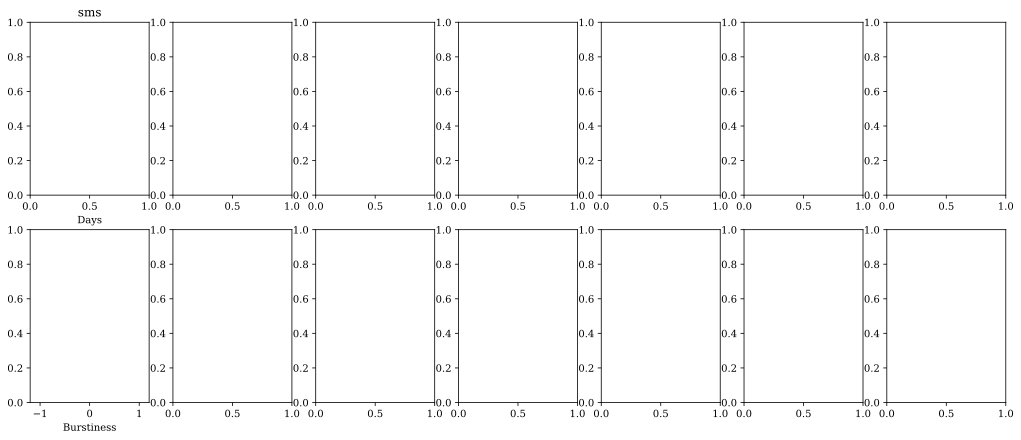

In [82]:
fig, axs = plt.subplots(2, len(names), figsize =(2.5*len(names), 7))# sharey='row')#, sharex='row') #sharey='row'
c = ['blue', 'orange', 'grey']
labels = ['Non-Reciprocal','Reciprocal', 'Overall']
lines   = [':', ':', '-']

names = ['sms']

for col,name in enumerate(names):
    
#     fit = param_fit[col]    
#     fit_burst = param_fit_burst[col]
    
    # - Setting the name of the column (dataset)
    axs[0,col].set_title(name)
    axs[0, col].set_xlabel('Days')
    axs[1, col].set_xlabel('Burstiness')
    axs[1, col].set_xlim(-1.2, 1.2); #<--- AM: I changed the range make the x axis larger
    
    # - Preparing data
    name_store = open('./graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()    
    df_nodes, df_edges = data_prep(g_filt)
    
    for row,var_list in enumerate([['intertime_no_rec_mean', 'intertime_rec_mean', 'intertime_mean'], ['burst_no_rec', 'burst_rec', 'burst']]): 
 
        for i in range(3):  
            variable = np.array([v for v in df_nodes[var_list[i]] if str(v)!= 'nan'])
            color = c[i]
            label = labels[i]
            axs[row, col].set_ylabel('')
            axs[row, col].axvline(np.mean(variable), 0, 21, c=c[i], alpha=0.7, ls='--', label='', lw=1.4)  
            
            
            if row == 1:
                # Burstiness
                axs[row, col].hist(variable,alpha = 0.5, density=False, edgecolor = c[i], label = label, color = c[i])
                
                #axs[row, col].set_xscale('log')
                #axs[row, col].set_xlim(0, 20)
            else:
                # log-scaled bins
                bins = np.logspace(0, 3, 20)
                widths = (bins[1:] - bins[:-1])

                # Calculate histogram
                hist = np.histogram(variable, bins=bins)
                hist_norm = hist[0]/widths

                # plot it!
                axs[row, col].bar(bins[:-1], hist_norm, widths,color = c[i],alpha = 0.5)
                axs[row, col].set_xscale('log')
                axs[row, col].set_yscale('log')
                
                
                #axs[row, col].hist(variable,alpha = 0.5, density=False, edgecolor = c[i], label = label, color = c[i], bins = 50)
                #axs[row, col].set_xscale('log')
                #axs[row, col].set_yscale('log')
                #axs[row, col].set_xlim(0, 20)
                #x,y = cum_F_x(variable)
                #y =1-y
        
                # Lines
                #axs[row, col].plot(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.6 )
                #axs[row, col].scatter(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.01, marker = 'o' )
                
                #axs[row, col].set_yscale('log')
                #axs[row, col].set_xscale('log')
                #axs[row, col].set_ylim(10*-4,10*0)
        
                
            
            
f = 10
axs[0,0].set_ylabel('$P_{x}(Intertime)$',fontsize=f)
axs[1,0].set_ylabel('$P_{x}(Burstiness)$',fontsize=f)

axs[1,3].legend(loc='lower center', ncol = 3, bbox_to_anchor=(0.5, -0.5))
#plt.tight_layout(pad=0.02)#h_pad=1.0
#plt.show()
fig.savefig(fig_path+'/fig2_2.pdf')